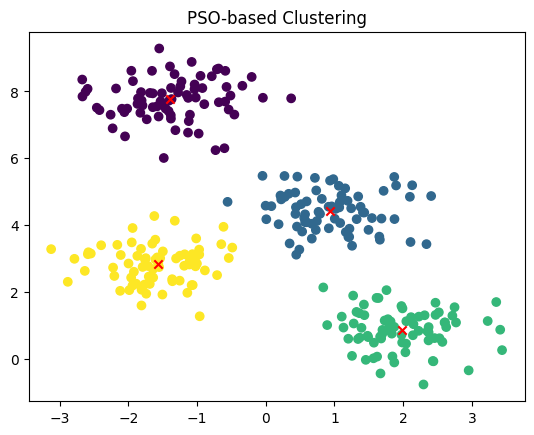

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic data
data, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# PSO parameters
num_particles = 30
num_iterations = 100
num_clusters = 4
w = 0.5       # inertia weight
c1 = 1.5      # cognitive coefficient
c2 = 1.5      # social coefficient

# Initialize particles
class Particle:
    def __init__(self, data, num_clusters):
        self.data = data
        self.num_clusters = num_clusters
        self.position = data[np.random.choice(range(len(data)), num_clusters)]
        self.velocity = np.zeros_like(self.position)
        self.best_position = np.copy(self.position)
        self.best_score = self.evaluate()

    def evaluate(self):
        distances = np.linalg.norm(self.data[:, None] - self.position[None, :], axis=2)
        closest = np.argmin(distances, axis=1)
        score = sum(np.linalg.norm(self.data[i] - self.position[closest[i]])**2 for i in range(len(self.data)))
        return score

    def update(self, global_best):
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        self.velocity = w * self.velocity + cognitive + social
        self.position += self.velocity
        score = self.evaluate()
        if score < self.best_score:
            self.best_score = score
            self.best_position = np.copy(self.position)

# Initialize swarm
swarm = [Particle(data, num_clusters) for _ in range(num_particles)]
global_best = min(swarm, key=lambda p: p.best_score).best_position

# PSO loop
for _ in range(num_iterations):
    for particle in swarm:
        particle.update(global_best)
    global_best = min(swarm, key=lambda p: p.best_score).best_position

# Final clustering
distances = np.linalg.norm(data[:, None] - global_best[None, :], axis=2)
labels = np.argmin(distances, axis=1)

# Plot results
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.scatter(global_best[:, 0], global_best[:, 1], c='red', marker='x')
plt.title("PSO-based Clustering")
plt.show()

Excellent — this code demonstrates how **Particle Swarm Optimization (PSO)** can be used as a **clustering algorithm**, similar in spirit to k-means but using **swarm intelligence** instead of gradient-based optimization. Let’s break it down *step by step*, line by line, with full reasoning and intuitive understanding.

---

## 🧩 1️⃣ Importing Libraries

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
```

**Purpose of each:**

| Library                       | Purpose                                         |
| ----------------------------- | ----------------------------------------------- |
| `numpy`                       | Vectorized math operations and matrix handling  |
| `matplotlib.pyplot`           | Plotting data points and clusters               |
| `sklearn.datasets.make_blobs` | Generates synthetic, clustered data for testing |

---

## 🧩 2️⃣ Generate Synthetic Data

```python
data, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
```

* Creates **300 sample points** around **4 cluster centers**.
* Each cluster has a standard deviation of **0.60**, meaning they’re somewhat separated but still overlapping.
* `random_state=0` ensures reproducibility.
* The underscore `_` ignores the true labels — we only care about the **data** itself for unsupervised clustering.

✅ **Goal:** Find 4 cluster centroids *without knowing the labels.*

---

## 🧩 3️⃣ PSO Parameters

```python
num_particles = 30
num_iterations = 100
num_clusters = 4
w = 0.5       # inertia weight
c1 = 1.5      # cognitive coefficient
c2 = 1.5      # social coefficient
```

These control the **PSO algorithm’s behavior**.

| Parameter        | Meaning                                | Role                                    |
| ---------------- | -------------------------------------- | --------------------------------------- |
| `num_particles`  | Number of candidate solutions (agents) | More particles → better exploration     |
| `num_iterations` | Number of optimization steps           | Controls how long PSO runs              |
| `num_clusters`   | Number of cluster centers (K)          | Equivalent to k-means’ “k”              |
| `w`              | Inertia weight                         | Controls how much past velocity matters |
| `c1`             | Cognitive term                         | Tendency to return to personal best     |
| `c2`             | Social term                            | Tendency to move toward global best     |

---

## 🧩 4️⃣ Defining the Particle Class

This is the **core of PSO**. Each particle represents one *possible clustering solution* — a set of centroids.

```python
class Particle:
    def __init__(self, data, num_clusters):
        self.data = data
        self.num_clusters = num_clusters
        self.position = data[np.random.choice(range(len(data)), num_clusters)]
        self.velocity = np.zeros_like(self.position)
        self.best_position = np.copy(self.position)
        self.best_score = self.evaluate()
```

### 🔍 Inside the `__init__`:

| Variable             | Meaning                                                              |
| -------------------- | -------------------------------------------------------------------- |
| `self.position`      | The current centroids (randomly selected from data points initially) |
| `self.velocity`      | Movement vector for centroids (initially zeros)                      |
| `self.best_position` | The best centroids this particle has ever found                      |
| `self.best_score`    | The corresponding clustering error (fitness value)                   |

---

## 🧩 5️⃣ Fitness Function — Cluster Quality

```python
def evaluate(self):
    distances = np.linalg.norm(self.data[:, None] - self.position[None, :], axis=2)
    closest = np.argmin(distances, axis=1)
    score = sum(np.linalg.norm(self.data[i] - self.position[closest[i]])**2 for i in range(len(self.data)))
    return score
```

**Explanation:**

1. `self.data[:, None] - self.position[None, :]`
   → Computes pairwise distances between **every point** and **every centroid**.

2. `np.linalg.norm(..., axis=2)`
   → Euclidean distance between each data point and centroid.

3. `closest = np.argmin(distances, axis=1)`
   → Finds which centroid is closest to each data point.

4. `score = sum(...)`
   → The **sum of squared distances** of each point to its nearest centroid.
   This is the *objective function* (same as k-means).
   Lower score = better clustering.

---

## 🧩 6️⃣ Update Rule for Each Particle

```python
def update(self, global_best):
    r1, r2 = np.random.rand(), np.random.rand()
    cognitive = c1 * r1 * (self.best_position - self.position)
    social = c2 * r2 * (global_best - self.position)
    self.velocity = w * self.velocity + cognitive + social
    self.position += self.velocity
    score = self.evaluate()
    if score < self.best_score:
        self.best_score = score
        self.best_position = np.copy(self.position)
```

Each iteration, every particle **moves** based on:

* Its **previous velocity** (momentum, controlled by `w`)
* Its **personal best position** (self-improvement)
* The **global best position** (social cooperation)

### Motion Breakdown:

| Term                                             | Meaning   | Effect                                     |
| ------------------------------------------------ | --------- | ------------------------------------------ |
| `w * self.velocity`                              | Inertia   | Keeps particle moving in same direction    |
| `c1 * r1 * (self.best_position - self.position)` | Cognitive | Pulls toward best solution found by itself |
| `c2 * r2 * (global_best - self.position)`        | Social    | Pulls toward the swarm’s best solution     |

After updating, the particle recalculates its **fitness**.
If the new position is better (lower score), it updates its personal best.

---

## 🧩 7️⃣ Initialize Swarm

```python
swarm = [Particle(data, num_clusters) for _ in range(num_particles)]
global_best = min(swarm, key=lambda p: p.best_score).best_position
```

* Creates 30 particles (candidate clustering solutions).
* Chooses the one with the **lowest score** as the **global best** (so far).

---

## 🧩 8️⃣ PSO Iterative Optimization

```python
for _ in range(num_iterations):
    for particle in swarm:
        particle.update(global_best)
    global_best = min(swarm, key=lambda p: p.best_score).best_position
```

**Process per iteration:**

1. Each particle updates its position and evaluates new score.
2. After all updates, find the **current best** among all particles.
3. Update the global best for the next iteration.

Over many iterations, particles gradually **converge** to good centroid locations.

---

## 🧩 9️⃣ Final Clustering Assignment

```python
distances = np.linalg.norm(data[:, None] - global_best[None, :], axis=2)
labels = np.argmin(distances, axis=1)
```

* After optimization, assign each data point to its **nearest final centroid** (in `global_best`).

Result:
`labels` gives the cluster each point belongs to (0, 1, 2, 3).

---

## 🧩 🔟 Visualization

```python
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.scatter(global_best[:, 0], global_best[:, 1], c='red', marker='x')
plt.title("PSO-based Clustering")
plt.show()
```

* Plots data points colored by cluster assignment.
* Plots **final centroids** as red `x` marks.
* You should see 4 main groups, with red crosses near their centers — confirming convergence.

---

## 🧠 Conceptual Summary

| Step | Description                                                         |
| ---- | ------------------------------------------------------------------- |
| 1    | Generate sample data (4 blobs)                                      |
| 2    | Create swarm of particles, each representing a set of centroids     |
| 3    | Each particle moves under influence of its own and global best      |
| 4    | Evaluate using sum of squared distances (same as k-means objective) |
| 5    | Update global best iteratively                                      |
| 6    | After convergence, assign points to nearest centroids               |
| 7    | Visualize clusters                                                  |

---

## ⚙️ Comparison: PSO vs K-Means

| Feature        | K-Means                            | PSO Clustering                          |
| -------------- | ---------------------------------- | --------------------------------------- |
| Initialization | Random centroids                   | Random centroids (via swarm)            |
| Optimization   | Gradient-based (Lloyd’s algorithm) | Population-based heuristic              |
| Objective      | Minimize intra-cluster distance    | Same objective                          |
| Convergence    | Deterministic (fast)               | Stochastic (exploration-based)          |
| Advantage      | Simple and fast                    | Avoids local minima; global exploration |
| Disadvantage   | Sensitive to init                  | Slower, computationally heavier         |

---

## 🚀 Extensions or Improvements

1. **Dynamic inertia weight:**
   Decrease `w` over time to allow better convergence.

2. **Hybrid PSO–KMeans:**
   Use PSO to initialize centroids, then fine-tune with k-means (best of both worlds).

3. **Fitness normalization:**
   Scale objective values to stabilize particle updates.

4. **Visualize evolution:**
   Track centroid movement across iterations for insight.

---

### ✅ Final Intuitive Recap

Each *particle* is like a **flock bird** flying in search of the **best cluster positions**.
They communicate with each other (global best) and themselves (personal best) to improve over time.
When they all settle near optimal cluster centers, PSO has successfully “discovered” the true clusters — much like how birds flock toward the best feeding spot.

---
